In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from tqdm import tqdm
from theano.tensor.random.utils import RandomStream
import scipy.linalg as sl
import scipy.stats as ss
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import lightkurve as lk

starry.config.quiet = True
np.random.seed(1)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/sabina/.lightkurve/cache. Please move all the files in the legacy directory /Users/sabina/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
def _cho_solve(L, b):
    return tt.slinalg.solve_upper_triangular(L.T, tt.slinalg.solve_lower_triangular(L, b))

class StarryStarryProcess(object):
    def __init__(self, sys, sp, nt, nlm):
        self._sys = sys
        self._sp = sp
        self._nt = nt
        self._nlm = nlm

        self._mu = sp.mean_ylm
        self._Lambda = sp.cov_ylm

    @property
    def nt(self):
        return self._nt
    @property
    def nlm(self):
        return self._nlm

    @property
    def sys(self):
        return self._sys
    @property
    def sp(self):
        return self._sp
    
    @property
    def mu(self):
        return self._mu
    @property
    def Lambda(self):
        return self._Lambda
    
    @property
    def primary(self):
        return self.sys.primary
    @property
    def secondary(self):
        return self.sys.secondaries[0]
    
    @property
    def design_matrix(self):
        return self._M

    @property
    def logl_marginal(self):
        return self._logl_marginal
    @property
    def a(self):
        return self._a
    @property
    def AInv_chol(self):
        return self._AInv_chol

    def _compute(self, t, flux, sigma_flux):
        M = self.sys.design_matrix(t)[:,:-1] # We don't use any flux from the secondary, so [:, :-1]
        self._M = M

        nlm = self.nlm
        nt = self.nt

        mu = self.mu
        Lambda = self.Lambda

        # We want to enforce that the prior on the constant term in the map is
        # completely flat, so we set the first row and column of the precision
        # matrix to zero we do this manually here.  First we Cholesky decompose:
        #
        # Lambda[1:,1:] = L L^T
        #
        # Then, because of a quirk of theano (no gradients for `cho_solve!`,
        # WTF), we can compute Lambda[1:,1:]^{-1} via
        #
        # Lambda[1:,1:]^{-1} = tt.slinalg.solve_triangular(L.T, tt.slinalg.solve_triangular(L, tt.eye(nlm-1), lower=True), lower=False)
        #
        # encapsulated in our _cho_solve(...) function above
        L = tt.slinalg.cholesky(Lambda[1:,1:])
        Lambda_inv = _cho_solve(L, tt.eye(nlm-1))
        Lambda_inv = tt.set_subtensor(tt.zeros((nlm, nlm))[1:,1:], Lambda_inv)

        sigma_flux2 = tt.square(sigma_flux)
        MTCinv = M.T / sigma_flux2[None, :]
        MTCinvM = tt.dot(MTCinv, M)

        AInv = Lambda_inv + MTCinvM
        AInv_chol = tt.slinalg.cholesky(AInv)
        a = _cho_solve(AInv_chol, tt.dot(Lambda_inv, mu) + tt.dot(MTCinv, flux))

        self._a = a
        self._AInv_chol = AInv_chol

        b = tt.dot(M, mu)
        r = flux - b

        Cinvr = r / sigma_flux2

        rtilde = Cinvr - tt.dot(MTCinv.T, tt.slinalg.solve(AInv, tt.dot(MTCinv, r)))

        # Identity:
        # |B| = |I + M^T C^-1 M L| |C| = |L^-1 + M^T C^-1 M| |L| |C|
        # But we want to cancel the infinite constant in L[0,0], so we ignore the first row and column of L:
        # |B| = | A^-1 | |L[1:,1:]| |C|

        logdetB = tt.sum(tt.log(sigma_flux2)) + 2*tt.sum(tt.log(tt.diag(AInv_chol))) + 2*tt.sum(tt.log(tt.diag(L)))

        # (nt-1) because we have cancelled one dimension due to the flat prior on the [0,0] constant term.
        logl = -0.5*tt.dot(r, rtilde) - 0.5*logdetB - 0.5*(nt-1)*tt.log(2*np.pi)
        self._logl_marginal = logl

    def marginal_likelihood(self, t, flux, sigma_flux):
        self._compute(t, flux, sigma_flux)
        return self.logl_marginal
    
    def sample_ylm_conditional(self, t, flux, sigma_flux, size=1, rng=None):
        if rng is None:
            rng = RandomStream(seed=np.random.randint(1<<32))

        nylm = self.nlm

        self._compute(t, flux, sigma_flux)
        return self.a[None,:] + tt.slinalg.solve_upper_triangular(self.AInv_chol.T, rng.normal(size=(nylm, size))).T

## Helper Distribution functions

In [3]:
def Inclination(name, testval=30):
    """
    An isotropic distribution for inclination angles (in degrees).
    
    """
    def logp(x):
        return tt.log(np.pi / 180 * tt.sin(x * np.pi / 180))

    def random(*args, **kwargs):
        return tt.arccos(pm.Uniform.dist(0, 1).random(*args, **kwargs)) * 180 / np.pi

    return pm.DensityDist(
        name,
        logp,
        random=random,
        initval=testval,
    )


def Angle(*args, **kwargs):
    """
    A uniform distribution for angles in [-180, 180).
    
    """
    if kwargs.get("testval", None) is not None:
        kwargs["testval"] *= np.pi / 180
    return 180 / np.pi * pmx.Angle(*args, **kwargs)

def ori_xyz(name, testval):
    stellar_ori_x = pm.Normal(name+'_ori_x', mu=0, sigma=1, testval=testval)
    stellar_ori_y = pm.Normal(name+'_ori_y', mu=0, sigma=1, testval=testval)
    stellar_ori_z = pm.Normal(name+'_ori_z', mu=0, sigma=1, testval=testval)

    return stellar_ori_x, stellar_ori_y, stellar_ori_z

def Planet_Inc(name, *args, **kwargs):
    bmax = params[name].get('bmax')
    b = pm.Uniform('b', -bmax, bmax)
    planet_inc = pm.Deterministic(name, 180.0/np.pi*np.arccos(b))
    
    return planet_inc

def Stellar_Ang(name, *args, **kwargs):
    if kwargs.get("testval", None) is not None:
        trueval = kwargs["testval"]
    stellar_ori_x, stellar_ori_y, stellar_ori_z = ori_xyz(name, trueval)

    if "inc" in name:
        return pm.Deterministic(name, 180.0/np.pi*tt.arccos(stellar_ori_z / tt.sqrt(tt.square(stellar_ori_x) + tt.square(stellar_ori_y) + tt.square(stellar_ori_z))))
    
    elif "obl" in name:
        return pm.Deterministic(name, 180.0/np.pi*tt.arctan2(stellar_ori_y, stellar_ori_x))

def Period(name, *args, **kwargs):
    Ttotal = t[-1] - t[0]
    frac_bounds = params[name].get('frac_bounds')

    if kwargs.get("testval", None) is not None:
        trueval = kwargs["testval"]

    def logp(trueval, frac_bounds):
        return pm.Uniform(name+'logp',tt.log(trueval) + np.log1p(-frac_bounds), tt.log(trueval) + np.log1p(frac_bounds))

    period = pm.Deterministic(name, tt.exp(logp(trueval, frac_bounds)))

    return period

def Logarithmic(name, *args, **kwargs):
    if kwargs.get("testval", None) is not None:
        trueval = kwargs["testval"]
    log_rp = pm.Uniform(name+'log', tt.log(trueval/2), tt.log(2*trueval))
    rp = pm.Deterministic(name, tt.exp(log_rp))

    return rp

# Shorthand for the usual Uniform distribution
Uniform = pm.Uniform

In [4]:
def gp_model(t, flux, err, params):

    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
            
        else:
            return param["truth"]
    
    
    starry.config.lazy = True
    
    with pm.Model() as model:

        prot = parameter('star.prot')
        stellar_inc = parameter('star.inc')
        stellar_obl = parameter('star.obl')

        porb = parameter('planet.porb')
        t0 = parameter('planet.t0')
        rp = parameter('planet.r')
        planet_inc = parameter('planet.inc')
        mp = parameter('planet.m')
        ecc = parameter('planet.ecc')
        Omega = parameter('planet.Omega')

        pri_model = starry.Primary(starry.Map(ydeg=15, udeg=2, inc=stellar_inc, obl=stellar_obl), 
            r=parameter('star.r'), 
            m=parameter('star.m'), 
            prot=prot, 
            t0=0.0)
        pri_model.map[1] = parameter('star.u1')
        pri_model.map[2] = parameter('star.u2')

        sec_model = starry.Secondary(starry.Map(0,0), 
            t0=t0, 
            r=rp, 
            m=mp, 
            prot=1,
            porb=porb, 
            ecc=ecc, 
            Omega=Omega, 
            inc=planet_inc)
    
        sys_model = starry.System(pri_model, sec_model)

        # Instantiate the GP
        sp_model = StarryProcess(
            mu=parameter("gp.mu"),
            sigma=parameter("gp.sigma"),
            r=parameter("gp.r"),
            dr=parameter("gp.dr"),
            c=parameter("gp.c"),
            n=parameter("gp.n"),
            ydeg=15,
            udeg=2,
            marginalize_over_inclination=False,  
        )

        ssp_model = StarryStarryProcess(sys_model, sp_model, len(t), 256)

        pm.Potential('marginal_likelihood', ssp_model.marginal_likelihood(t, flux, err))
        
        return model

In [5]:
def bin_out_of_transit(t, flux, err, params, dt=0.06, binsize=30):
    """
    Bin the out of transit points to speed things up.
    
    """
    # Find in-transit and out-of-transit points
    idx = np.zeros(len(t), dtype=bool)
    ntransits = int(np.ceil(t[-1] / params["planet.porb"]["truth"]))
    for n in range(ntransits):
        t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
        idx |= ((t > t0 - dt) & (t < t0 + dt))
    t_in = t[idx]
    f_in = flux[idx]
    t_out = t[~idx]
    f_out = flux[~idx]

    # Make the size of the out-of-transit array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t_out) % binsize
    t_out = t_out[:-trim]
    f_out = f_out[:-trim]

    # We need to be careful not to bin *across* the transit, so
    # let's NaN-out points right _before_ each transit
    f_out[np.where(np.diff(t_out) > 0.1)] = np.nan

    # Bin the out-of-transit data
    t_out = t_out.reshape(-1, binsize).mean(axis=1)
    f_out = f_out.reshape(-1, binsize).mean(axis=1)

    # Remove any nans (the averages *across* transits)
    idx = np.isnan(f_out)
    t_out = t_out[~idx]
    f_out = f_out[~idx]

    # Error arrays
    e_in = err[0] * np.ones_like(t_in)
    e_out = (err[0] / np.sqrt(binsize)) * np.ones_like(t_out)

    # Sort and merge the arrays
    t_ = np.concatenate((t_in, t_out))
    f_ = np.concatenate((f_in, f_out))
    e_ = np.concatenate((e_in, e_out))
    idx = np.argsort(t_)
    t_ = t_[idx]
    flux_ = f_[idx]
    err_ = e_[idx]

    return t_, flux_, err_

## Get a light curve

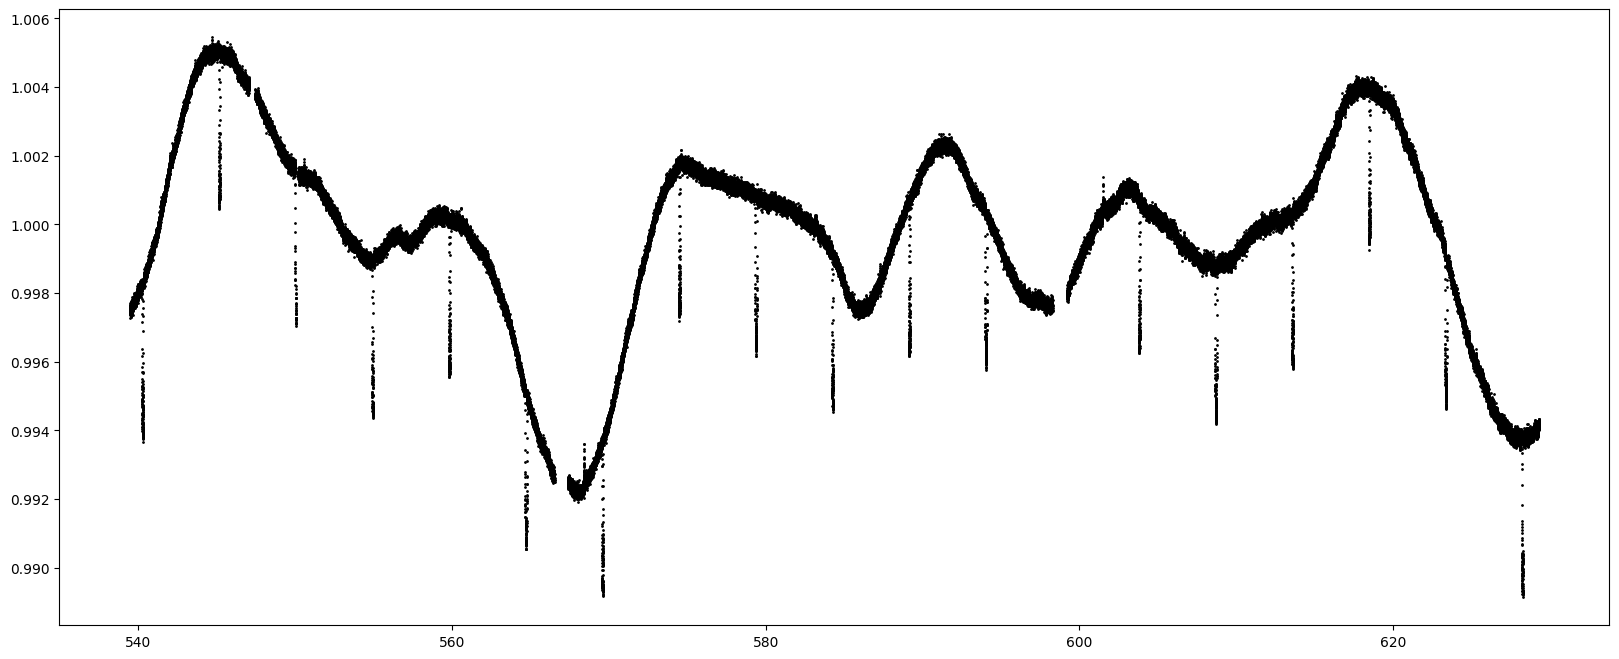

In [6]:
search_result = lk.search_lightcurve('HAT-P-11', author='Kepler', cadence='short', quarter=6)
# Download all available Kepler light curves
lc_collection_q6 = search_result.download_all()

search_result = lk.search_lightcurve('HAT-P-11', author='Kepler', cadence='short')
# Download all available Kepler light curves
lc_collection = search_result.download_all()

all_lc = lc_collection.stitch()
lc_q6 = lc_collection_q6.stitch()

all_lc=all_lc.remove_nans()
lc_q6 = lc_q6.remove_nans()

all_lc = all_lc[all_lc.quality==0]
lc_q6 = lc_q6[lc_q6.quality == 0]

plt.figure(figsize=(20, 8))
plt.plot(lc_q6.time.value, lc_q6.flux, "k.", ms=2)

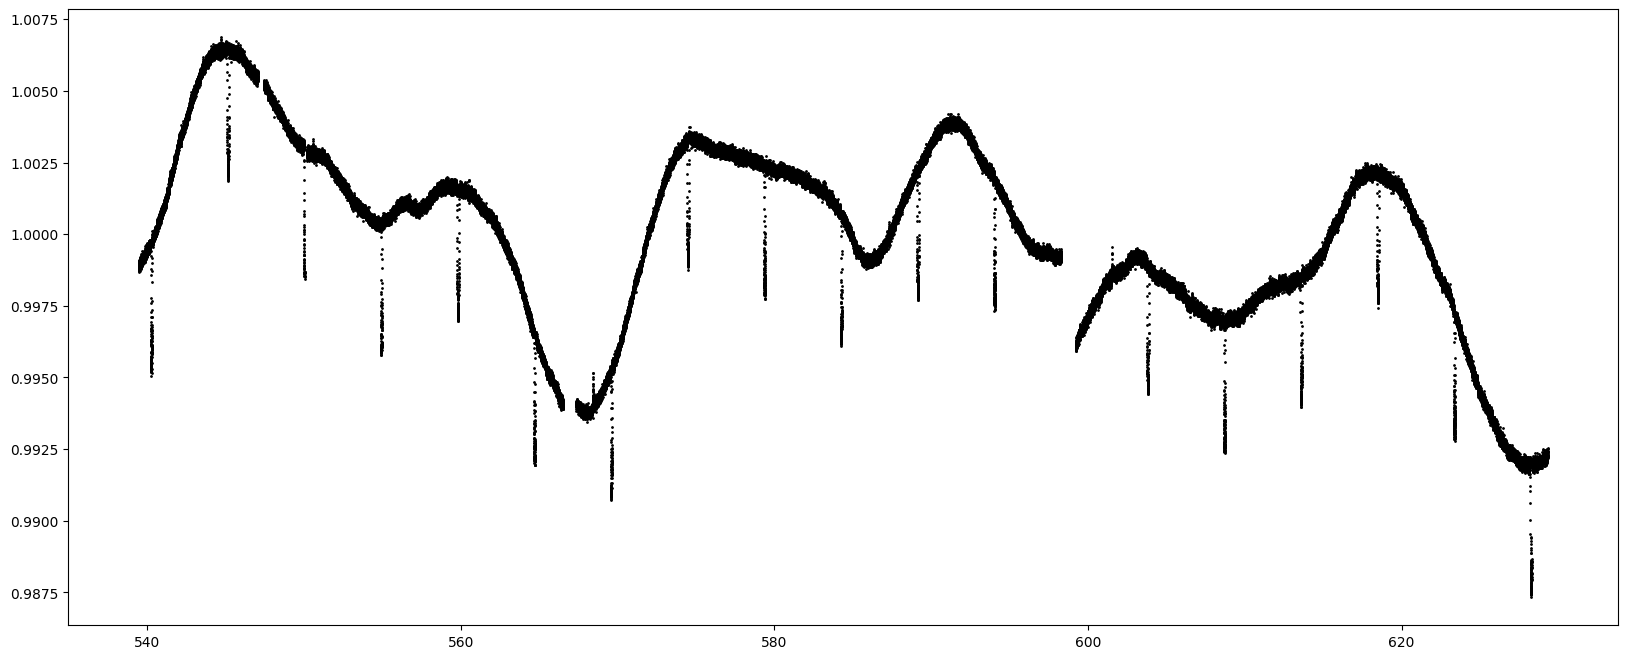

In [7]:
t = lc_q6.time.value #saving the times
flux = np.array(lc_q6.pdcsap_flux.value) # saving the fluxes with PDCSAP
mean_flux = np.mean(np.array(lc_q6.pdcsap_flux.value))
flux_obs = flux / mean_flux

sigma_flux = np.array(lc_q6.pdcsap_flux_err.value) / mean_flux

data = list(zip(t, flux_obs, sigma_flux))

sorted_data = sorted(data, key=lambda x: x[0])

sorted_times, sorted_fluxes, sorted_errors = zip(*sorted_data)

t = np.array(sorted_times)
flux_obs = np.array(sorted_fluxes)
sigma_flux = np.array(sorted_errors)

plt.figure(figsize=(20, 8))
plt.plot(t, flux_obs, "k.", ms=2)

In [8]:
mSun = 1.989e33 # grams
mJ = 1.898e30 
rJ = 6.99e6 # cm
rSun = 69.634e6

mHATP11b = 0.0736 * mJ # grams
mHATP11 = 0.809 * mSun
rHATP11b = 0.389 * rJ # cm
rHATP11 = 0.683 * rSun 

In [9]:
rHATP11 / rSun

0.683

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


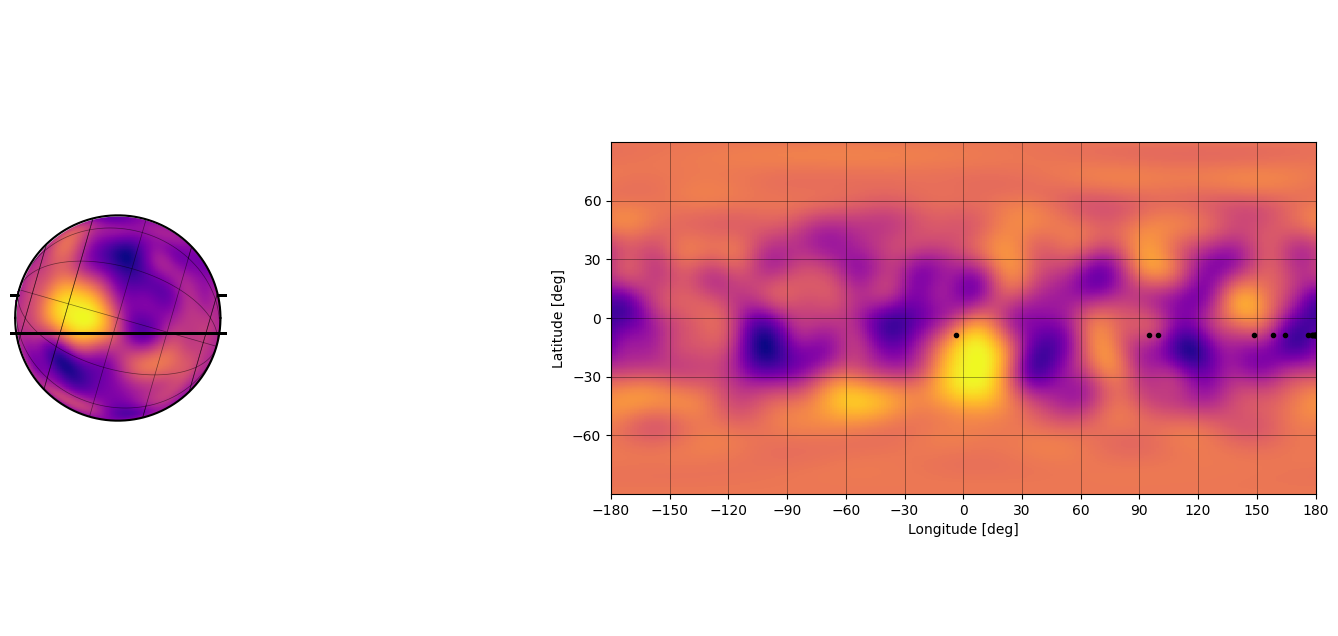

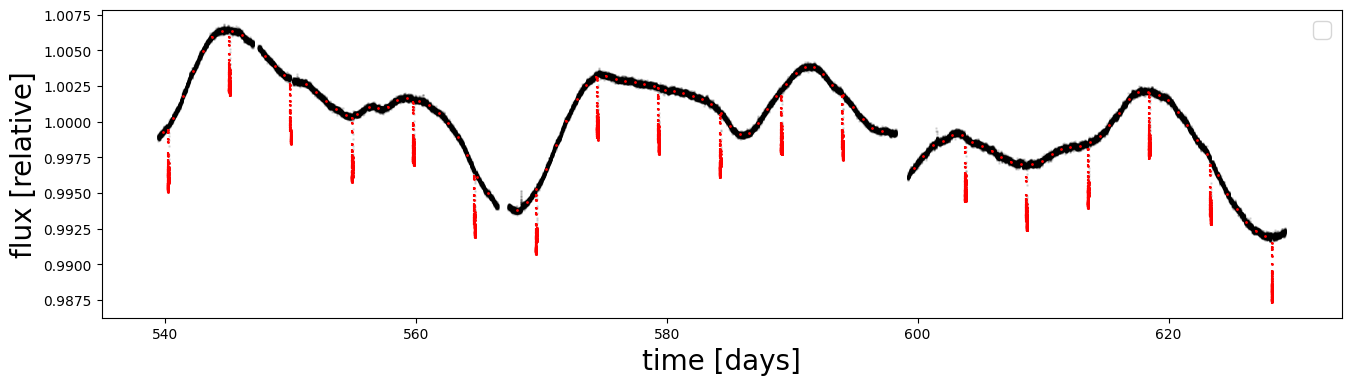

In [16]:
# True parameters & priors
params = {
    "planet.inc": {"truth": 89.05, "dist": Planet_Inc},
    "planet.ecc": {"truth": 0.2, "dist": Uniform, "args": [0.0, 0.9]},
    "planet.Omega": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 4.887802443, "dist": Period},
    "planet.t0": {"truth": 124.81, "dist": Uniform, "args": [124.6, 125.1]},
    "planet.r": {"truth": rHATP11b / rSun, "dist": Logarithmic},
    "planet.m": {"truth":  mHATP11b / mSun, "dist": Uniform, "args": [0.00001, 0.0001]},

    "star.inc": {"truth": 90, "dist": Stellar_Ang},
    "star.m": {"truth": mHATP11 / mSun, "dist": Uniform, "args": [0.4, 1]},
    "star.u1": {"truth": 0.646, "dist": Uniform, "args": [0.0, 0.8]},
    "star.u2": {"truth": 0.048, "dist": Uniform, "args": [0.0, 0.1]},
    "star.prot": {"truth": 29.77, "dist": Period},
    "star.obl": {"truth": -106.0, "dist": Stellar_Ang},
    "star.r": {"truth": rHATP11 / rSun, "dist": Uniform, "args": [0.1, 1]},

    "gp.r": {"truth": 20, "dist": Uniform, "args": [5.0, 35.0]},
    "gp.dr": {"truth": 5.0, "dist": Uniform, "args": [1.0, 10.0]},
    "gp.c": {"truth": 0.3, "dist": Uniform, "args": [0.1, 0.9]},
    "gp.n": {"truth": 15, "dist": Uniform, "args": [0, 60]},
    "gp.mu": {"truth": 15, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 10, "dist": Uniform, "args": [1.0, 30]}
}

t_, flux_, sigma_flux_ = bin_out_of_transit(t, flux_obs, sigma_flux, params, dt=0.045, binsize=1000)

# Initializing the time
Ttr_half = 0.1
dt_in_transit = Ttr_half / 20.0
dt_out_transit = params['star.prot']['truth'] / 20.0

dt = 0.6
idx = np.zeros(len(t_), dtype=bool)
ntransits = int(np.ceil(t_[-1] / params["planet.porb"]["truth"]))
for n in range(ntransits):
    t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
    idx |= ((t_ > t0 - dt) & (t_ < t0 + dt))
t_in = t_[idx]
t_out = t_[~idx]
flux_in = flux_[idx]
flux_out = flux_[~idx]

nt = len(t)

Ttotal = t[-1] - t[0]

# Setting the priors
# fraction bounds for period priors
prot_frac_bounds = min(params['star.prot']['truth']/Ttotal/2, 0.25)
porb_frac_bounds = min(params['planet.porb']['truth']/Ttotal/2, 0.25)

# Let's add this parameter to the parameter dictionary as a prior
params['star.prot']['frac_bounds'] = prot_frac_bounds
params['planet.porb']['frac_bounds'] = porb_frac_bounds

# semi-major axis
a = (params['star.m']['truth']*np.square(params['planet.porb']['truth']/365.25))**(1/3) * 215.03 # Solar radii
# impact parameter
bmax = params['star.r']['truth'] / a

# Let's add this parameter to the parameter dictionary as a prior
params['planet.inc']['bmax'] = bmax

# Plot the data

map = starry.Map(15, 2)
map.inc = params["star.inc"]["truth"]
map.obl = params["star.obl"]["truth"]
map[1] = params["star.u1"]["truth"]
map[2] = params["star.u2"]["truth"]
star = starry.Primary(map, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=params["star.prot"]["truth"]) 
planet = starry.Secondary(
    starry.Map(0,0),
    inc=params["planet.inc"]["truth"],
    ecc=params["planet.ecc"]["truth"],
    Omega=params["planet.Omega"]["truth"],
    porb=params["planet.porb"]["truth"],
    t0=params["planet.t0"]["truth"],
    r=params["planet.r"]["truth"],
    m=params["planet.m"]["truth"],
)

sys = starry.System(star, planet)
xo, yo, zo = sys.position(t)
xo = xo.eval()[1]
yo = yo.eval()[1]
zo = zo.eval()[1]
theta = (360 * t / params["star.prot"]["truth"]) % 360

# *** Draw 1 sample from the GP
sp = StarryProcess(
    mu=params["gp.mu"]["truth"],
    sigma=params["gp.sigma"]["truth"],
    r=params["gp.r"]["truth"],
    dr=params["gp.dr"]["truth"],
    c=params["gp.c"]["truth"],
    n=params["gp.n"]["truth"],
)

nt = len(t_)
ssp = StarryStarryProcess(sys, sp, len(t), 256)

y_true = sp.sample_ylm().eval().reshape(-1)
y_true[0] += 1

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
ax[0].set_aspect(1)
ax[0].axis("off")
map[:, :] = y_true
map.show(ax=ax[0])
ax[0].set_ylim(-3, 3)
idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
lat = 180 / np.pi * np.arcsin(yo[idx])
lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
lon = (lon + 180) % 360 - 180
mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
mask[mask == 1] = np.nan
map.show(ax=ax[1], projection="rect")
ax[1].plot(lon, lat + mask, "k.");

fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t, flux_obs, 'k.', ms=2, alpha=0.1)
ax.errorbar(t_, flux_, yerr=sigma_flux_, fmt='.', ms=2, color='red')
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

In [17]:
nt

2096

<ErrorbarContainer object of 3 artists>

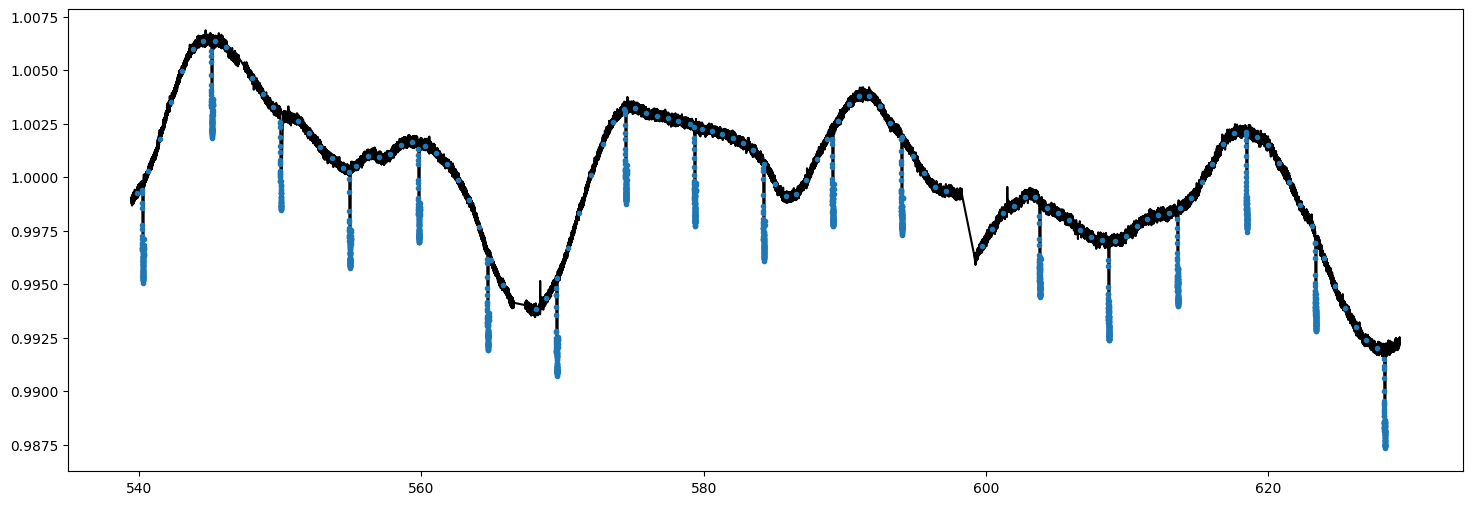

In [18]:
plt.figure(figsize=(18,6))
plt.plot(t, flux_obs, color='k')
plt.errorbar(t_, flux_, yerr=sigma_flux_, fmt='.')

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


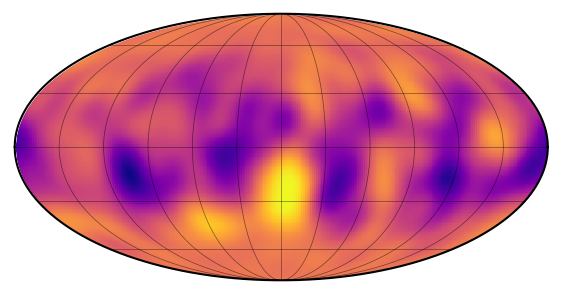

In [13]:
sp.visualize(y_true)

In [14]:
ylm_draw = ssp.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


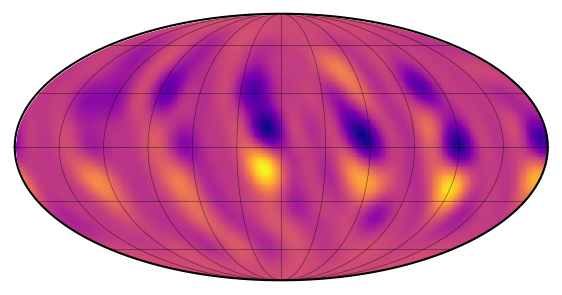

In [15]:
sp.visualize(ylm_draw)

In [16]:
resid = flux_obs - ssp.design_matrix.eval() @ ylm_draw
np.sum(ss.norm(loc=0, scale=sigma_flux).logpdf(resid)) - 0.5*np.dot(ylm_draw[1:] - sp.mean_ylm.eval()[1:], np.linalg.solve(sp.cov_ylm.eval()[1:,1:], ylm_draw[1:] - sp.mean_ylm.eval()[1:])) - 0.5*np.linalg.slogdet(sp.cov_ylm.eval()[1:,1:])[1] - 0.5*(len(ylm_draw)-1)*np.log(2*np.pi)

-37058948.58541637

In [20]:
whitened_ylm_resid = np.dot(ssp.AInv_chol.T.eval(), ylm_draw - ssp.a.eval())
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval() - 0.5*np.dot(whitened_ylm_resid, whitened_ylm_resid) + np.sum(np.log(np.diag(ssp.AInv_chol.eval()))) - 0.5*len(ylm_draw)*np.log(2*np.pi)

-37058979.92306813

In [21]:
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval()

array(-37060476.45344602)

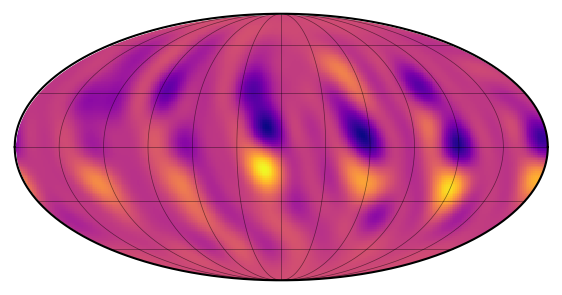

In [17]:
sp.visualize(ssp.a.eval())

In [18]:
sys.show(t_)

# Inference

In [19]:
# Set some free params & get the model
p = dict(params)

p['planet.t0']['free'] = True

free = [x for x in p.keys() if p[x].get("free", False)]
model = gp_model(t_, flux_, sigma_flux_, p)

In [20]:
free

['planet.t0']

In [21]:
# Optimize
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")

optimizing logp for variables: [planet.t0]



planet.t0: 124.81309299959317 [124.81]


message: Desired error not necessarily achieved due to precision loss.
logp: -30167193.03378181 -> -30155202.020997692


In [22]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        chains=1,
        cores=4,
        target_accept=0.9,
        return_inferencedata=False,
    )

Sequential sampling (1 chains in 1 job)
NUTS: [planet.t0]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1795 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


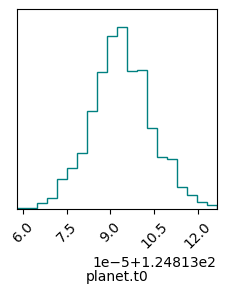

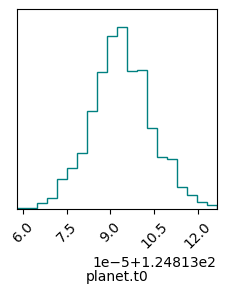

In [23]:
samples = pm.trace_to_dataframe(trace,varnames=free)
corner(np.array(samples),labels=free,truths=[params[x]['truth'] for x in free], color='teal', truth_color='orchid')

In [24]:
samples

,planet.t0
0,124.813100
1,124.813086
2,124.813089
3,124.813089
4,124.813102
...,...
995,124.813111
996,124.813114
997,124.813112
998,124.813121


### let's save our trace

In [25]:
az.to_netcdf(trace,'SSP-hatp11-t0.nc')

Got error No model on context stack. trying to find log_likelihood in translation.


/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


'SSP-hatp11-t0.nc'

In [26]:
# the summary
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
planet.t0,124.813,0.0,124.813,124.813,0.0,0.0,403.0,413.0,NaN


### now, let's work with the samples from the file

In [27]:
samples_fromfile = az.from_netcdf('SSP-hatp11-t0.nc')

In [28]:
samples = samples_fromfile.posterior.to_dataframe()

In [29]:
samples

planet.t0
chain draw            
0     0     124.813100
      1     124.813086
      2     124.813089
      3     124.813089
      4     124.813102
...                ...
      995   124.813111
      996   124.813114
      997   124.813112
      998   124.813121
      999   124.813124

[1000 rows x 1 columns]

In [31]:
np.mean(samples['planet.t0'][0])

124.81309376057825

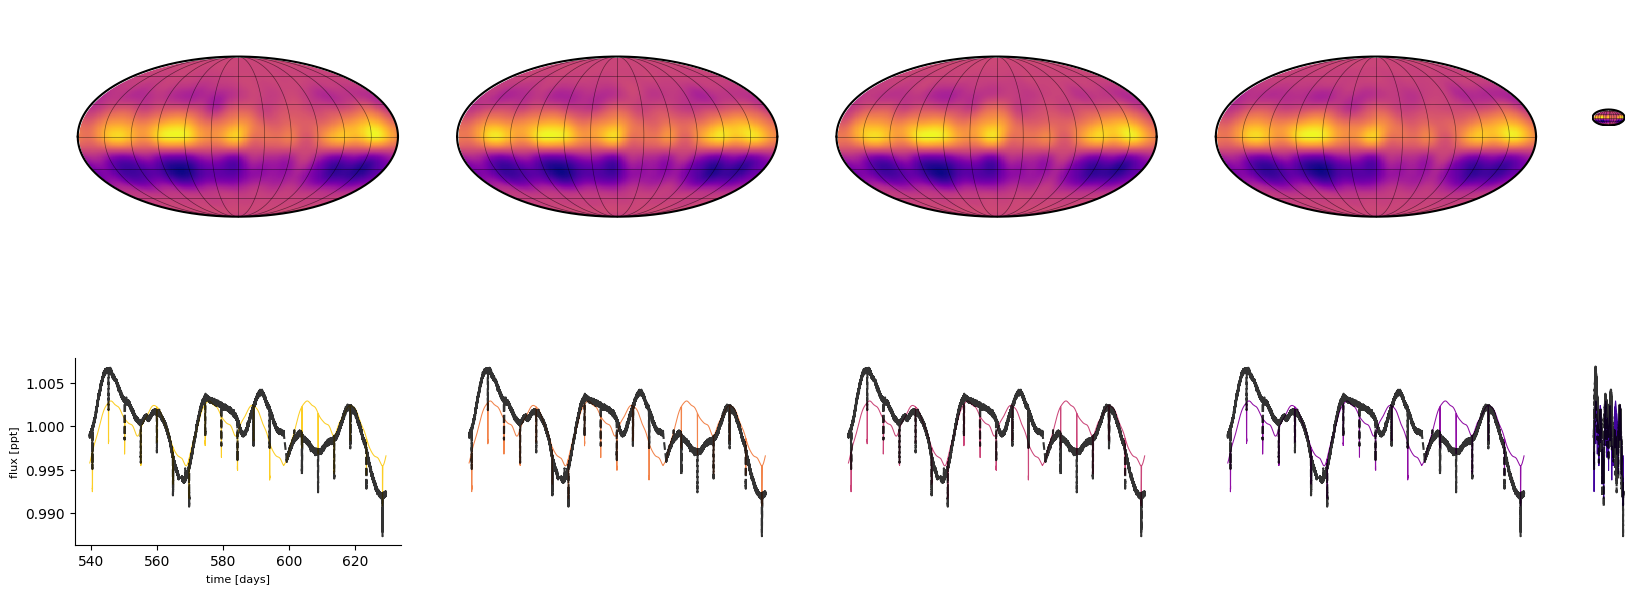

In [33]:
# plotting 5 samples
nsamples = 5
norm = Normalize(vmin=0.5, vmax=1.1)
cmap = plt.get_cmap("plasma_r")
color = lambda i: cmap(0.1 + 0.8 * i / (nsamples - 1))


fig, ax = plt.subplots(
    2,
    nsamples,
    figsize=(20, 8),
    gridspec_kw={
        "height_ratios": np.tile([1, 0.5], 1),
        "width_ratios": np.append(np.ones(nsamples-1), 0.1),
    },
)

for k in range(nsamples):
    # get a random sample from the posterior distributions
    rand_index = np.random.randint(0,samples.shape[0])
    map_samples = starry.Map(15, 2)
    star = starry.Primary(map_samples, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=params["star.prot"]['truth'], 
                          obl=params["star.obl"]["truth"], inc=params["star.inc"]["truth"]) 
    planet = starry.Secondary(
        starry.Map(0,0),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        porb=params["planet.porb"]['truth'],
        t0=samples["planet.t0"][0][rand_index],
        r=params["planet.r"]['truth'],
        m=params["planet.m"]["truth"],
        prot=1.0
    )

    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    
    sp_samples = StarryProcess(
        mu=params["gp.mu"]['truth'],
        sigma=params["gp.sigma"]['truth'],
        r=params["gp.r"]['truth'],
        dr=params["gp.dr"]["truth"],
        c=params["gp.c"]['truth'],
        n=params["gp.n"]['truth'],
    )

    nt = len(t)
    ssp_samples = StarryStarryProcess(sys, sp_samples, nt, len(star.map.y.eval()))

    ylm_samples = ssp_samples.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

    map_samples[:, :] = ylm_samples.reshape(-1)
    map_samples.show(ax=ax[0, k], projection="moll")
    ax[0, k].set_ylim(-1.5, 2.25)
    ax[0, k].set_rasterization_zorder(1)
    flux_samples = sys.design_matrix(t).eval()[:, :-1] @ ylm_samples
    ax[1, k].plot(t, flux_samples, color=color(k), lw=0.75, alpha=1)
    ax[1, k].plot(t, flux_obs, 'k--', alpha=0.8)

    if k == 0:
        ax[1, k].spines["top"].set_visible(False)
        ax[1, k].spines["right"].set_visible(False)
        ax[1, k].set_xlabel("time [days]", fontsize=8)
        ax[1, k].set_ylabel("flux [ppt]", fontsize=8)
    else:
        ax[1, k].axis("off")
